# Imports and Defaults

In [15]:
import json
import os
from collections import namedtuple
from functools import lru_cache
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
sns.set_theme(font_scale=2, style="whitegrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.dpi": 300,
})

seed = 1234
rng = np.random.default_rng(seed)

# Load Data

In [44]:
posterior = "eight_schools-eight_schools_centered"
num_chains = 100

In [45]:
fname = f"../../../ceph/ceph_drghmc/data_rebuttal/{posterior}/baseline"

drghmc_sampler = "adapt_metric=True__damping=0.08__max_proposals=3__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drghmc__step_count_method=const_step_count__step_size_factor=2"
drhmc_sampler = "adapt_metric=True__damping=1.0__max_proposals=4__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drhmc__step_count_factor=0.9__step_size_factor=2"
nuts_sampler = "adapt_metric=True__metric=identity__sampler_type=nuts"

In [46]:
def get_fname(sampler, chain):
    return os.path.join(fname, sampler, f"metrics__chain={chain}.npz")

def get_chain_data(sampler, chain):
    data = np.load(get_fname(sampler, chain))
    return (
        data["error_param"][-1], 
        data["error_param_squared"][-1], 
        data["error_paran_l2"][-1], 
        data["error_param_squared_l2"][-1]
    )

In [47]:
@lru_cache(maxsize=3)
def get_data(sampler):
    e1_norm_inf, e2_norm_inf, e1_norm_l2, e2_norm_l2 = [], [], [], []
    for chain in range(num_chains):
        errors = get_chain_data(sampler, chain) # draws = (n_samples, n_params)
        e1_norm_inf.append(errors[0])
        e2_norm_inf.append(errors[1])
        e1_norm_l2.append(errors[2])
        e2_norm_l2.append(errors[3])
    
    return e1_norm_inf, e2_norm_inf, e1_norm_l2, e2_norm_l2

In [48]:
drghmc_errors = get_data(drghmc_sampler)
# drhmc_errors = get_data(drhmc_sampler)
nuts_errors = get_data(nuts_sampler)

In [49]:
# data to put into pd dataframe for all errors
data = {
    "sampler": ["DR-G-HMC"]*num_chains + ["NUTS"]*num_chains,
    "e1_norm_inf": drghmc_errors[0] + nuts_errors[0],
    # "e2_norm_inf": drghmc_errors[1] + nuts_errors[1],
    "e1_norm_l2": drghmc_errors[2] + nuts_errors[2],
    # "e2_norm_l2": drghmc_errors[3] + nuts_errors[3],
}

data = pd.DataFrame(data)
# melt into columns sampler, error, norm, val, with two melt operations
data = pd.melt(data, id_vars=["sampler"], var_name="error", value_name="val")
# split error into norm ("l2", or "inf") and error
# data = data.assign(norm=data.error.str.extract(r"_(\w+)$"), error=data.error.str.extract(r"^(.*)_"))
data

,sampler,error,val
0,DR-G-HMC,e1_norm_inf,0.104124
1,DR-G-HMC,e1_norm_inf,0.025407
2,DR-G-HMC,e1_norm_inf,0.058276
3,DR-G-HMC,e1_norm_inf,0.173217
4,DR-G-HMC,e1_norm_inf,0.136523
...,...,...,...
395,NUTS,e1_norm_l2,0.143475
396,NUTS,e1_norm_l2,0.102151
397,NUTS,e1_norm_l2,0.057034
398,NUTS,e1_norm_l2,0.369625


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, '$2$-Norm')

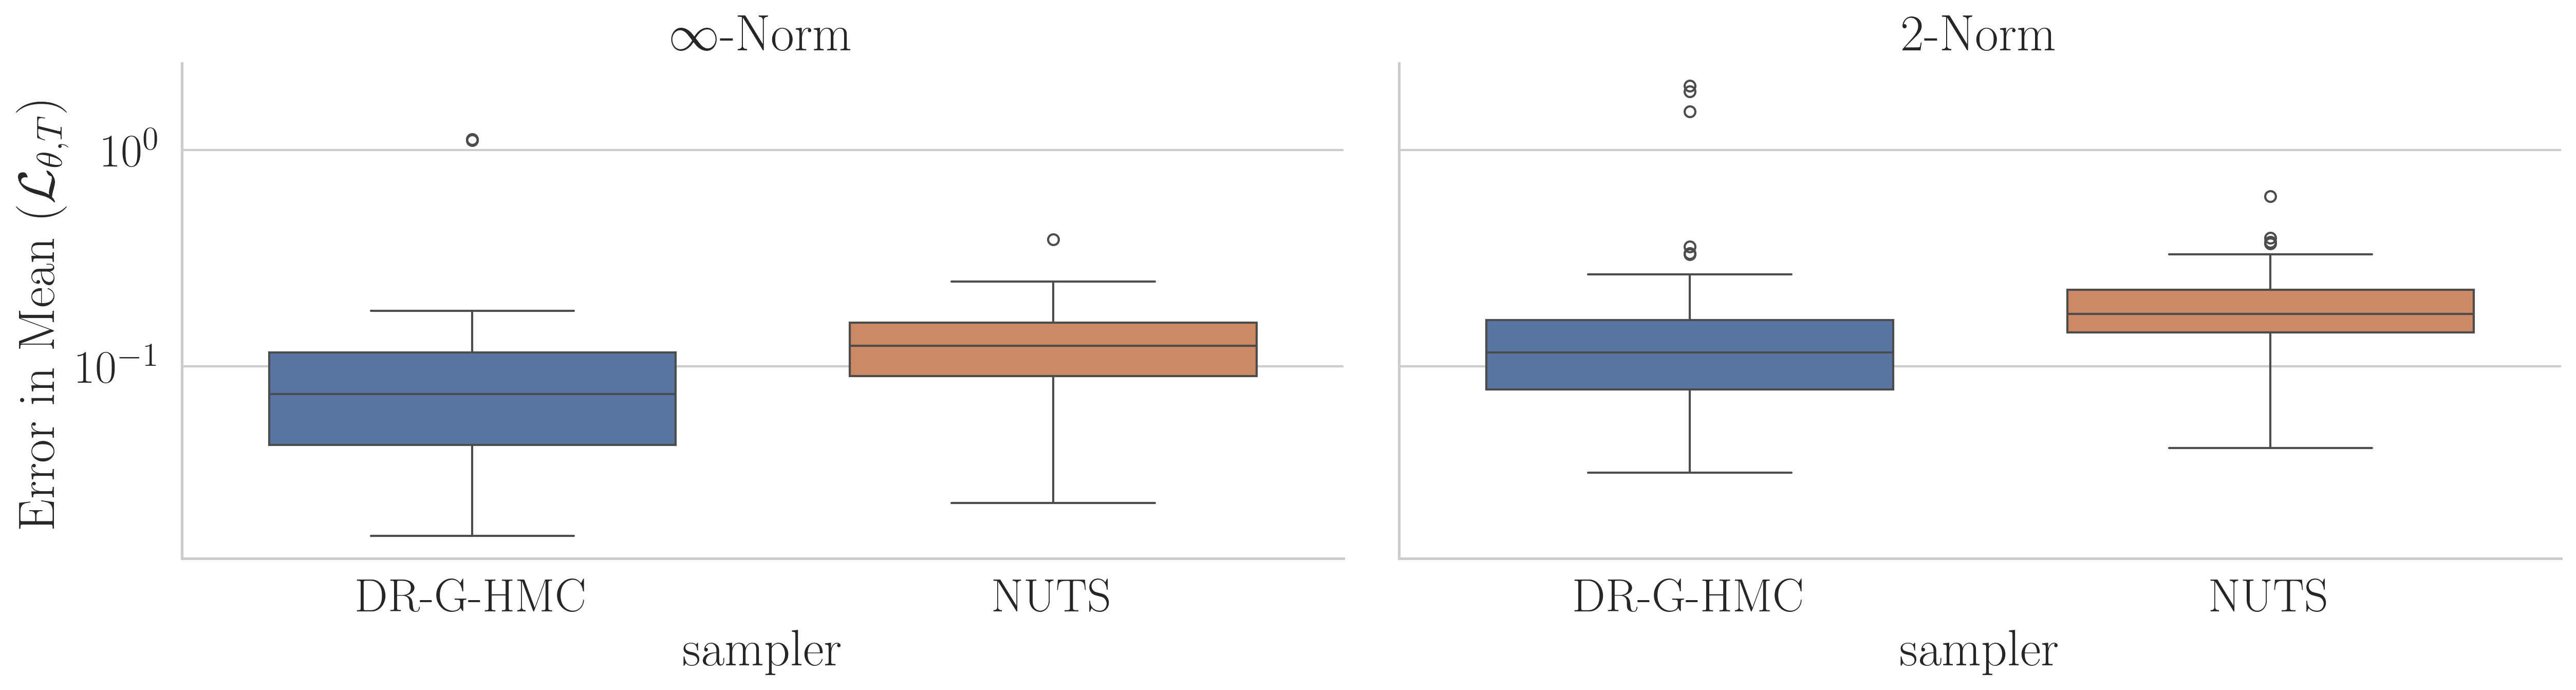

In [50]:
fig = sns.catplot(
    data=data, 
    kind="box",
    x="sampler",
    y="val",
    hue="sampler",
    col="error",
    # row="norm",
    aspect=1.7,
    width=0.7,
)

fig.set(yscale="log")
fig.set_ylabels(r'Error in Mean ($\mathcal{L}_{\theta, T}$)')
fig.axes.flat[0].set_title(r'$\infty$-Norm')
fig.axes.flat[1].set_title(r'$2$-Norm')
# fig.axes.flat[0].set_title(r'$\infty$-Norm For Error in Mean ($\mathcal{L}_{\theta, T}$)')
# fig.axes.flat[1].set_title(r'$\infty$-Norm For Error in Variance ($\mathcal{L}_{\theta^2, T}$)')
# fig.axes.flat[2].set_title(r'$2$-Norm For Error in Mean ($\mathcal{L}_{\theta, T}$)')
# fig.axes.flat[3].set_title(r'$2$-Norm For Error in Variance ($\mathcal{L}_{\theta^2, T}$)')